# COGS 118B - Final Project

# Names

- Abdul Ibrahim
- Kai Stern
- Patrick Helcl

# Abstract 

This study has the goal of utilizing more unique stock features to better cluster stock companies and their performance by using Gaussian Mixture Models instead of traditional K-means clustering methods. Our datasets were sourced from Kaggle rather than traditional financial sites for the added benefit of extra stock features (e.g stock splits) that are usually left out. This gives us the opportunity to try and identify more complex patterns that are unseen with simpler methods and features. We hope this project will present better investment opportunities by analyzing how the stocks are clustered together as well as identifying patterns that point towards growth. Our success will be measured by shedding light on the use of GMM in the stock analysis space by measuring the silhouette score to our baseline k-means model.

# Background

Stock choice and market prediction have been growing applications of machine learning (ML) over the last several decades. Recognizing and understanding patterns is crucial for both research and successful trading in a system as dynamic and complex as the stock market. Supervised learning approaches to stock market ML analysis typically require deep domain knowledge and extensive human contribution to perform feature engineering <a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1). Automating this process frees up researchers to focus on other aspects of the problem and enables a lower domain knowledge threshold. Thus, there has been increasing interest in the use of unsupervised algorithms for financial ML purposes. Unsupervised clustering algorithms can help uncover unexpected structure within unlabelled data to suggest areas of research or give a competitive advantage for traders <a name="cite_ref-2"></a>[<sup>2</sup>](#cite_note-2). Principal components analysis (PCA) can help to group data based on the characteristics that contribute most to its variability <a name="cite_ref-3"></a>[<sup>3</sup>](#cite_note-3). Most research on the use of unsupervised learning for financial data is focused on the k-means clustering algorithm which has been found to be a good indicator of high and low volatility conditions across asset classes <a name="cite_ref-2"></a>[<sup>2</sup>](#cite_note-2). Multiple papers cited k-means’ poorer performance on messy data without spherical clusters as a limitation of the algorithm that could be overcome in future research by applying mixture models <a name="cite_ref-2"></a>[<sup>2</sup>](#cite_note-2) <a name="cite_ref-3"></a>[<sup>3</sup>](#cite_note-3) Other potential areas of research to avoid human feature engineering include self supervised learning so that algorithms can learn patterns from raw data themselves <a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1). We plan to build upon the literature by implementing a Gaussian Mixture Model clustering that is more generalizable and unique relative to other studies, many of which use a k-means based approach in their research. 


# Problem Statement

After conducting background research on our topic of interest, we identified that the vast majority of machine learning literature frequently uses k-means clustering (a simple algorithm which assumes spherical/circular covariance) when conducting studies on stock data. Our group seeks to understand how clustering and pattern recognition will change when using a more robust and flexible algorithm. Gaussian mixture models are our current algorithm of choice as they can assume a wider array of covariance shape when conducting machine learning research on stock data. This enables us to cluster based on more irregular or less easily separable data. We hope to uncover new insights and better pattern recognition in our research. Our goal from this endeavor is to find potential worthwhile stock investments based on our clustering. 

# Data

### Dataset 1

Link to dataset 1 here: https://www.kaggle.com/datasets/iveeaten3223times/massive-yahoo-finance-dataset

Size: 9 Variables, 603K observations 

##### Features of each observation: 

- Date: The date corresponding to the recorded stock market data.
- Open: The opening price of the stock on a given date.
- High: The highest price of the stock reached during the trading day.
- Low: The lowest price of the stock observed during the trading day.
- Close: The closing price of the stock on a specific date.
- Volume: The volume of shares traded on the given date.
- Dividends: Any dividend payments made by the company on that date (if applicable).
- Stock Splits: Information regarding any stock splits occurring on that date.
- Company: Ticker symbol or identifier representing the respective company.

##### Critical values for this dataset

Since we only have 9 features and each of which is directly connected to the stock price we intend on using all 9 features listed above.

##### Summary of cleaning:

Since our data set has few features and is from Kaggle the values in our data are already very clean. However our group did find that the date values were stored as strings and were inconviently stored as the date and the time in a single string. To make this feature more useable we wrote a helper function to clean the string into just the date and convert it into datetime object, supported by pandas, for easier use later in the project with the date attributes and since knowing the exact times of the stock each day would not be necessary due to the timescale of our project.

##### Why this data is important for our project?:

This data is important for our project because ...

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA


df1 = pd.read_csv('data/stock_details_5_years.csv', header=0)

def time_fixer(x):
    x = x.split(' ')[0]
    return x

df1['Date'] = df1['Date'].apply(time_fixer)
df1['Date'] = pd.to_datetime(df1['Date'])

df1.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


# Data 2 (wrangled from original set)

Dataframe created from the first data set. *full explanation somewhere here*. We are created a data frame from a subset of the data so that we can group the different stocks by their volatility and run our unsupervised learning / gmm model on the open and close data and leverage these features in the most informational way.

In [2]:
#todo - add comments explaining code later
company_opens = df1.groupby('Company')['Open'].apply(np.array)
company_closes = df1.groupby('Company')['Close'].apply(np.array)

changes_df = pd.DataFrame(index=company_opens.index)
changes_df['opens'] = company_opens
changes_df['closes'] = company_closes

def perc_change(open_ser, close_ser):

    return ((close_ser - open_ser) / open_ser )*100.0
    
data1 = perc_change(changes_df['opens'], changes_df['closes'] )

changes_df['perc_change'] = data1

full_length = changes_df['perc_change'].apply(len).max()

full_companies = changes_df['perc_change'].apply(len)

useable_companies = full_companies[full_companies == full_length]

# useable_companies

final_df = changes_df.loc[useable_companies.index]

final_df = final_df.drop(columns=['opens', 'closes'])
final_df.head(10)

,perc_change
Company,
A,"[0.4773218052326546, 1.0051671761984158, 1.827..."
AAPL,"[-1.702617183838854, -0.9484672021502785, 0.19..."
ABBV,"[1.011124035815082, 4.442714837058878, -0.6997..."
ABEV,"[0.7025810290951009, 0.2347359508779906, -0.68..."
ABT,"[1.1459365284516383, 0.1623194184859994, -0.02..."
ACGL,"[0.38910046417311844, 0.5975397952022214, -1.1..."
ACN,"[-0.702792270799572, 1.6999443205598022, 0.512..."
ADBE,"[1.1081327004284363, 0.2637588112448539, -2.09..."
ADI,"[-0.5112321590414718, 2.4749178330342025, 0.18..."


# Proposed Solution

After doing research on current literature in financial analysis using machine learning for the stock market, our group found that there was an overabundance of k-means in studies. This over use of k-means for clustering analysis and model selection was even addressed as a marker for need of further research in the subject by <a name="cite_ref-3"></a>[<sup>3</sup>](#cite_note-3). Our group seeks to expand to the current literature by using a Gaussian mixture model GMM for clustering of different attributes in the dataset, which can assume covariances other than spherical/circular unlike k-means which have fixed covariance assumptions. We aim to find new and/or more accurate clusterings and patterns than in previous research which could lead to more accurate analysis of stock performance. To determine if the GMM performs better than k-means, our group will also implement a k-means model trained on our data as a benchmark comparison for our findings and metrics. One such metric that will be used to compare the two is each model's Silhouette score. The silhouette score measures how well each cluster is separated from one another and each cluster’s density of data points. Comparing the silhouette score of each model will be a good measure of how well our GMM is performing relative to the k-means model, also giving our group an idea of how well our model stacks up to the models used in our background research articles. Our group also plans to use k-folds cross validation for hyperparameter tuning to ensure the best versions of each model are being compared. Our methodology should be highly reproducible especially if the same years of stock market data are used. Whether or not better metrics are achieved by our model compared to the k-means model, our project will shed light on ML based stock market analysis literature. This will be achieved by showing that our GMM out performed k-means inviting further research into the use of GMM in the space or alternately ruling out the use of GMM’s in further research and supporting the classic k-means and suggesting research into other models beyond the two are needed.

# Evaluation Metrics

We plan on using Silhouette score to evaluate our clusterings. This metric measures how well separated and dense clusters are. It returns a value between -1 and 1. Negative values suggest data points have been placed in the wrong clusters as data points are closer to points in other clusters. Values near 0 suggest highly overlapping clusters. Values near 1 suggest well separated clusters, dense clusters. Values near 1 are better for Silhouette score. Silhouette scores can break down if clusters are highly irregular. If that ends up being the case with our data we will supplement how we evaluate our models with other evaluation metrics such as adjusted rand score.


# Exploratory Data analysis: 


## PCA (Elbow method)

note: we are doing a pca elbow method here due to the high dimesionality of our data set

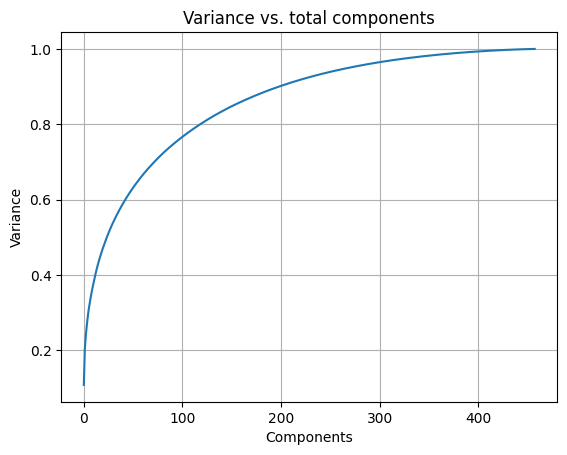

In [3]:
X = np.array(final_df['perc_change'].tolist())
pca = PCA()
pca.fit(X)

# elbow method shown here
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Variance')
plt.title('Variance vs. total components')
plt.grid(True)
plt.show()

# best 250


# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1 - Creating baseline GMM and K-means models

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.


# We are starting with 11 clusters because there are 11 industries in the S&P500

silhouette score: 0.04497999162079186


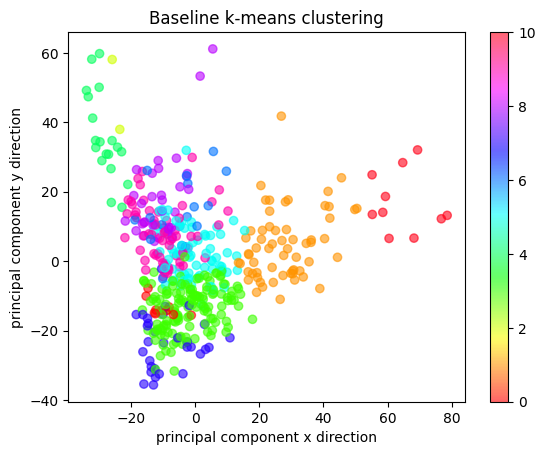

In [4]:
X = np.array(final_df['perc_change'].tolist())
pca = PCA(n_components=250) 
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=11, random_state=24) # use of 11 explained in writing above
cluster_labels = kmeans.fit_predict(X_pca)

silh_score = silhouette_score(X_pca, cluster_labels)
print('silhouette score:', silh_score)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='hsv', alpha=0.6)
plt.title('Baseline k-means clustering')
plt.xlabel('principal component x direction')
plt.ylabel('principal component y direction')
plt.colorbar()
plt.show()


silhouette score: 0.04661086724935972


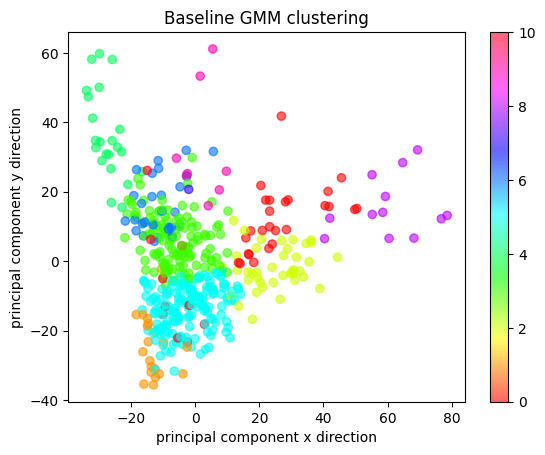

In [5]:
gmm = GaussianMixture(n_components=11, random_state=24)  
cluster_labels = gmm.fit_predict(X_pca)

silh_score = silhouette_score(X_pca, cluster_labels)
print('silhouette score:', silh_score)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='hsv', alpha=0.6)
plt.title('Baseline GMM clustering')
plt.xlabel('principal component x direction')
plt.ylabel('principal component y direction')
plt.colorbar()
plt.show()

### Subsection 2 - Cross validation and optimization of GMM and K-means base line models

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

best # of clusters: 2
Corresponding best cross validation silhouette score 0.19727005788182103


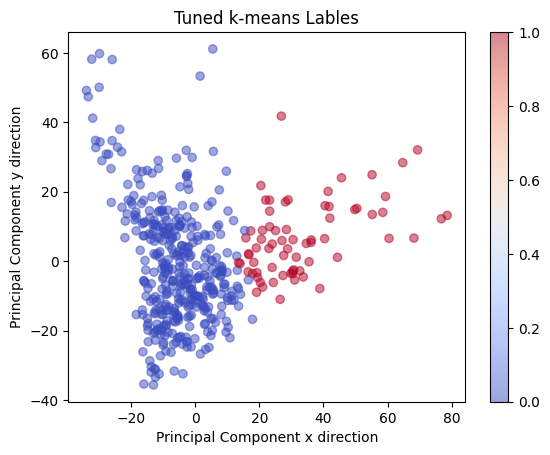

Silhouette score for graphed clustered: 0.19727005788182103


In [6]:
silhouette_scores = []

# corss validation here, note it is unseeded
for n_clusters in range(2, 19):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(X_pca)
    silh_score = silhouette_score(X_pca, cluster_labels)
    silhouette_scores += [silh_score]

final_cluster_num = np.argmax(silhouette_scores) + 2 # add 2 because corresponding index is left shifted

print("best # of clusters:", final_cluster_num)
print("Corresponding best cross validation silhouette score", silhouette_scores[final_cluster_num - 2])

#kmeans used new found best k param
kmeans = KMeans(n_clusters=final_cluster_num, random_state=24)
cluster_labels = kmeans.fit_predict(X_pca)

#saving labl results for later analysis in finl-df
final_df['k-means label'] = cluster_labels

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='coolwarm', alpha=0.5)
plt.title('Tuned k-means Lables')
plt.xlabel('Principal Component x direction')
plt.ylabel('Principal Component y direction')
plt.colorbar()
plt.show()

# silhoutte score from graphed kmeans clustering
final_silhouette_score = silhouette_score(X_pca, cluster_labels)
print("Silhouette score for graphed clustered:", final_silhouette_score)

best # of clusters: 2
Corresponding best cross validation silhouette score 0.20479030375577872


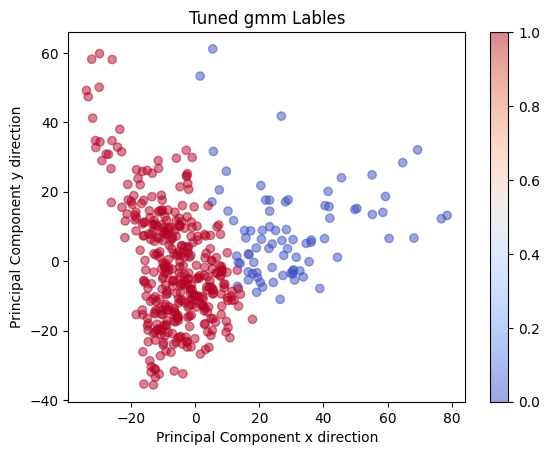

Silhouette score for graphed clustered: 0.1970361550957435


In [15]:
silhouette_scores = []

# cross validation here, note this part is unseeded
for n_components in range(2, 19):
    gmm = GaussianMixture(n_components=n_components)
    cluster_labels = gmm.fit_predict(X_pca)
    silh_score = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silh_score)

final_cluster_num = np.argmax(silhouette_scores) + 2

print("best # of clusters:", final_cluster_num)
print("Corresponding best cross validation silhouette score", silhouette_scores[final_cluster_num - 2])

gmm = GaussianMixture(n_components=final_cluster_num, random_state=24)
cluster_labels = gmm.fit_predict(X_pca)

# Update final_df with cluster labels
final_df['gmm labels'] = cluster_labels

# Plot the clustering labels

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='coolwarm', alpha=0.5)
plt.title('Tuned gmm Lables')
plt.xlabel('Principal Component x direction')
plt.ylabel('Principal Component y direction')
plt.colorbar()
plt.show()

final_silhouette_score = silhouette_score(X_pca, cluster_labels)
print("Silhouette score for graphed clustered:", final_silhouette_score)

### Subsection (3 or 4) - comparison of clusters from each model

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Lets find which companies were included in each cluster

In [16]:
# peak at data frame after adding labels from our models
final_df.head(8)

,perc_change,k-means label,gmm labels
Company,,,
A,"[0.4773218052326546, 1.0051671761984158, 1.827...",0,1
AAPL,"[-1.702617183838854, -0.9484672021502785, 0.19...",1,0
ABBV,"[1.011124035815082, 4.442714837058878, -0.6997...",0,1
ABEV,"[0.7025810290951009, 0.2347359508779906, -0.68...",0,1
ABT,"[1.1459365284516383, 0.1623194184859994, -0.02...",0,1
ACGL,"[0.38910046417311844, 0.5975397952022214, -1.1...",0,1
ACN,"[-0.702792270799572, 1.6999443205598022, 0.512...",0,1
ADBE,"[1.1081327004284363, 0.2637588112448539, -2.09...",1,0


now that we have labels we need to find which companies ended up in which cluster: 

In [17]:

kmeans_0 = final_df.index[final_df['k-means label'] == 0].values

kmeans_1 = final_df.index[final_df['k-means label'] == 1].values

gmm_0 = final_df.index[final_df['gmm labels'] == 0].values

gmm_1 = final_df.index[final_df['gmm labels'] == 1].values

#lengths of each 

print("k-means 0 length:", len(kmeans_0))
print("k-means 1 length:", len(kmeans_1))
print("gmm 0 length:", len(gmm_0))
print("gmm 1 length:", len(gmm_1), '\n')

# to visualize what these arrays look like here is a snippet of first 10 companies in the 1-label groups
print(gmm_1[0:10])
print(kmeans_1[0:10])


k-means 0 length: 389
k-means 1 length: 69
gmm 0 length: 81
gmm 1 length: 377 

['A' 'ABBV' 'ABEV' 'ABT' 'ACGL' 'ACN' 'ADM' 'ADP' 'AEE' 'AEM']
['AAPL' 'ADBE' 'ADI' 'ADSK' 'ALNY' 'AMAT' 'AMD' 'AMZN' 'ANET' 'ANSS']


### finding performance for each company over last 3 months (1 quarter)

In [18]:
last_quart_cutoff = df1['Date'].max() - timedelta(days=90)  #90 for 3 months (1 financial quarter)

final_quarter_only = df1[df1['Date'] >= last_quart_cutoff]

final_quarter_avgs = final_quarter_only.groupby('Company').mean()

final_quarter_avgs  = final_quarter_avgs.drop(columns=['Open', 'High', 'Low', 'Volume', "Dividends", 'Stock Splits'])
final_quarter_avgs

,Close
Company,
A,112.198726
AAPL,178.937359
ABBV,145.091578
ABEV,2.644470
ABNB,128.831905
...,...
YUM,123.770971
ZBH,111.488542
ZM,65.788254


#### finally making boxplots to show performance of each cluster

##### K-means first:

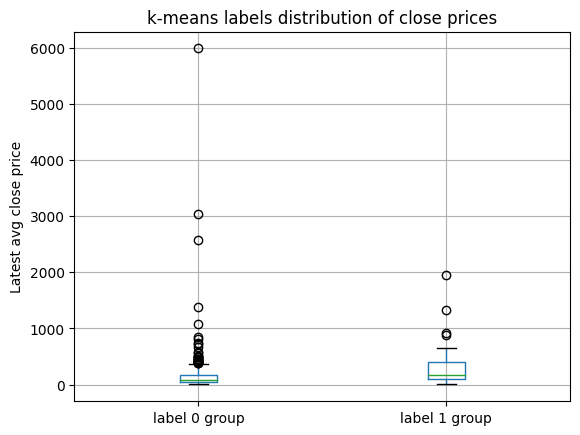

Median label 0 Median: 89.58465927366227
Lower quartile label 0: 43.047204153878354
Upper quartile label 0: 173.69358825683597 

Median for label 1 group: 173.7444445897663
Lower quartile label 1: 91.20233989897228
Upper quartile label 1: 398.13555714440736


In [19]:
#kmeans
kmean_0_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(kmeans_0)]
kmean_1_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(kmeans_1)]

fig, ax = plt.subplots()

box1 = kmean_0_avgs.boxplot(column='Close',  positions=[1])
box2 = kmean_1_avgs.boxplot(column='Close',  positions=[2])

ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('Latest avg close price')
ax.set_title('k-means labels distribution of close prices')

plt.show()

# after creating code for plot we use code below to print the actual values this is due to ranges being so different

kmeans0_median = kmean_0_avgs['Close'].median()
kmeans0_lower_q = kmean_0_avgs['Close'].quantile(0.25)
kmeans0_upper_q = kmean_0_avgs['Close'].quantile(0.75)

kmeans1_median = kmean_1_avgs['Close'].median()
kmeans1_lower_q = kmean_1_avgs['Close'].quantile(0.25)
kmeans1_upper_q = kmean_1_avgs['Close'].quantile(0.75)

print("Median label 0 Median:", kmeans0_median)
print("Lower quartile label 0:", kmeans0_lower_q)
print("Upper quartile label 0:", kmeans0_upper_q, '\n')

print("Median for label 1 group:", kmeans1_median)
print("Lower quartile label 1:", kmeans1_lower_q)
print("Upper quartile label 1:", kmeans1_upper_q)

plt.show()


### now we try it without outliers to "zoom" in more 

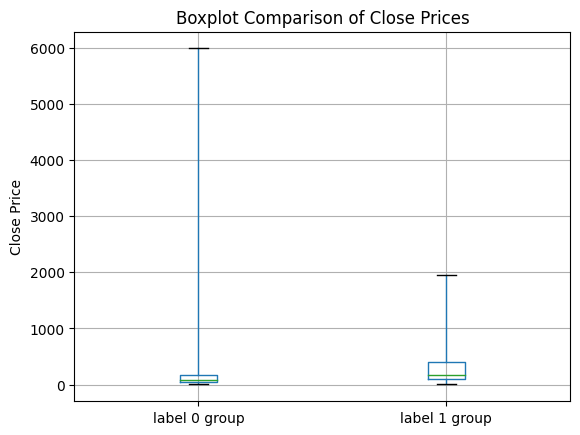

In [20]:
fig, ax = plt.subplots()

box1 = kmean_0_avgs.boxplot(column='Close',  positions=[1], whis=100)
box2 = kmean_1_avgs.boxplot(column='Close',  positions=[2], whis=15)

ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('Close Price')
ax.set_title('Boxplot Comparison of Close Prices')

plt.show()

### Now GMM:

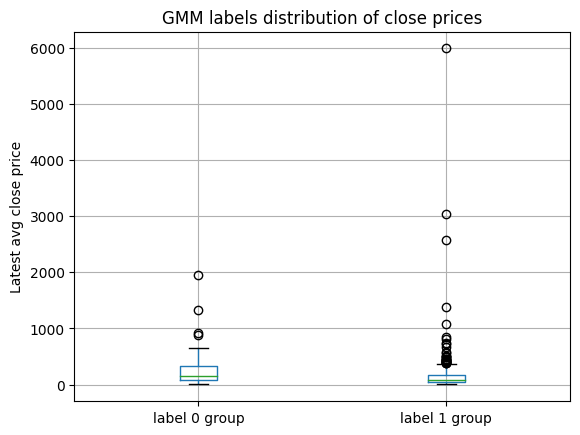

Median label 0 Median: 154.03589642237108
Lower quartile label 0: 83.67666638086713
Upper quartile label 0: 339.7681497240824 

Median for label 1 group: 89.58465927366227
Lower quartile label 1: 43.047204153878354
Upper quartile label 1: 173.89551532079298


In [21]:
#gmm
gmm_0_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_0)]
gmm_1_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_1)]

fig, ax = plt.subplots()

box1 = gmm_0_avgs.boxplot(column='Close',  positions=[1])
box2 = gmm_1_avgs.boxplot(column='Close',  positions=[2])

ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('Latest avg close price')
ax.set_title('GMM labels distribution of close prices')

plt.show()

gmm_0_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_0)]
gmm_1_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_1)]

gmm0_median = gmm_0_avgs['Close'].median()
gmm0_lower_q = gmm_0_avgs['Close'].quantile(0.25)
gmm0_upper_q = gmm_0_avgs['Close'].quantile(0.75)

gmm1_median = gmm_1_avgs['Close'].median()
gmm1_lower_q = gmm_1_avgs['Close'].quantile(0.25)
gmm1_upper_q = gmm_1_avgs['Close'].quantile(0.75)

print("Median label 0 Median:", gmm0_median)
print("Lower quartile label 0:", gmm0_lower_q)
print("Upper quartile label 0:", gmm0_upper_q, '\n')

print("Median for label 1 group:", gmm1_median)
print("Lower quartile label 1:", gmm1_lower_q)
print("Upper quartile label 1:", gmm1_upper_q)



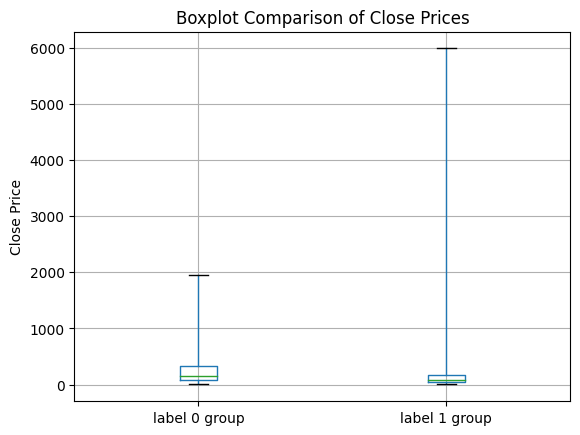

In [22]:
fig, ax = plt.subplots()

box1 = gmm_0_avgs.boxplot(column='Close',  positions=[1], whis=20)
box2 = gmm_1_avgs.boxplot(column='Close',  positions=[2], whis=100)

ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('Close Price')
ax.set_title('Boxplot Comparison of Close Prices')

plt.show()

### Subsection (3 or 4) - Neural net work stuff ? kai 

Probably you need to describe the base model and demonstrate its performance.  Maybe you include a learning curve to show whether you have enough data to do train/validate/test split or have to go to k-folds or LOOCV or ???

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   



### Ethics & Privacy

In regards to ethics and privacy our group’s project does not have any major ethical or privacy related concerns. Our project is built on data from publicly traded stocks of companies, which as the name implies are freely available to the public to access. 

Additionally, our data set does not contain any information about individuals since all data pertains to different companies, meaning we do not have to account for or worry about precautions such as personally identifiable data or major biases in data (e.g. political or socio economic). Additional benefits of using publicly available data on business and corporations instead of data from human beings include no need for informed consent, confidentiality and/or anonymity of participants. 

Since the data being used is from Kaggle, one potential issue with our data is the potential for altered or fabricated data about the different stocks and companies during scraping from the original poster. Some examples of this would include: errors in the data aggregation process or code that would store incorrect data, neglect of certain time periods or companies for sake of efficiency or information size, and personal bias from the data curator to select companies from yahoo finance based on some reason undisclosed on Kaggle (therefore unavailable for our group to identify). If any issues with the data are identified at any point in this project our group will take the necessary steps and precautions to identify, eliminate, or correct these issues and concerns.

Another potential concern as a result of the project is potential for our findings to influence stock investors which could theoretically have effects on the trading volume of different stocks or stocks with certain attributes identified with our models. In this scenario, the company's stock price would either be increased or decreased from our findings. However, it is worth noting that with our group member’s background and no previous experience in analyzing financial data we find this scenario to be extremely unlikely since our project should be viewed as a non reputable source and not comparable to suggestions from professional financial organizations. That being said, it is our group’s responsibility to identify any possible concerns and risks of the project no matter how likely. 

Overall this project has very few concerns and issues which also happen to be very unlikely after all things considered, thus this project should be free of any major confounds and issues that would make the accuracy and applicability of our findings questionable.



### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Team Expectations 

* *Schedule meetings and address concerns via text group chat*
* *Meet via zoom*
* *Break up work evenly; don't let one person carry the entire project*
* *Complete individual tasks in a timely manner*
* *Be open about strengths and weaknesses for project goals. Don't be afraid to ask for help*
* *Be open minded about other's ideas and have willingness to listen*

# Footnotes

1. <a name="cite_note-1"></a> [^](#cite_ref-1) Ying, Z. et al. (1 Feb 2024) Predicting stock market trends with self-supervised learning and extreme value theory. *Neurocomputing*. https://www.sciencedirect.com/science/article/abs/pii/S0925231223011566

2. <a name="cite_note-2"></a> [^](#cite_ref-2) Barradas, A., et al. (July, 2023) Identification of Patterns in the Stock Market through Unsupervised Algorithms. *MDPI*. https://www.mdpi.com/2813-2203/2/3/33

3. <a name="cite_note-3"></a> [^](#cite_ref-3) Lee, J. (1 Sep 2016) Clustering Approaches for Financial Data Analysis: a Survey. *School of Computer Science Science & Informatics, University College Dublin, Ireland*. https://arxiv.org/abs/1609.08520
